Hello User! This program will take in a section (topic) and a date from which a week will be added to see what keywords are most discussed.
Topic you would like to query: politics
Enter the start date (YYYYMMDD): 20200101
Enter the end date (YYYYMMDD): 20210101


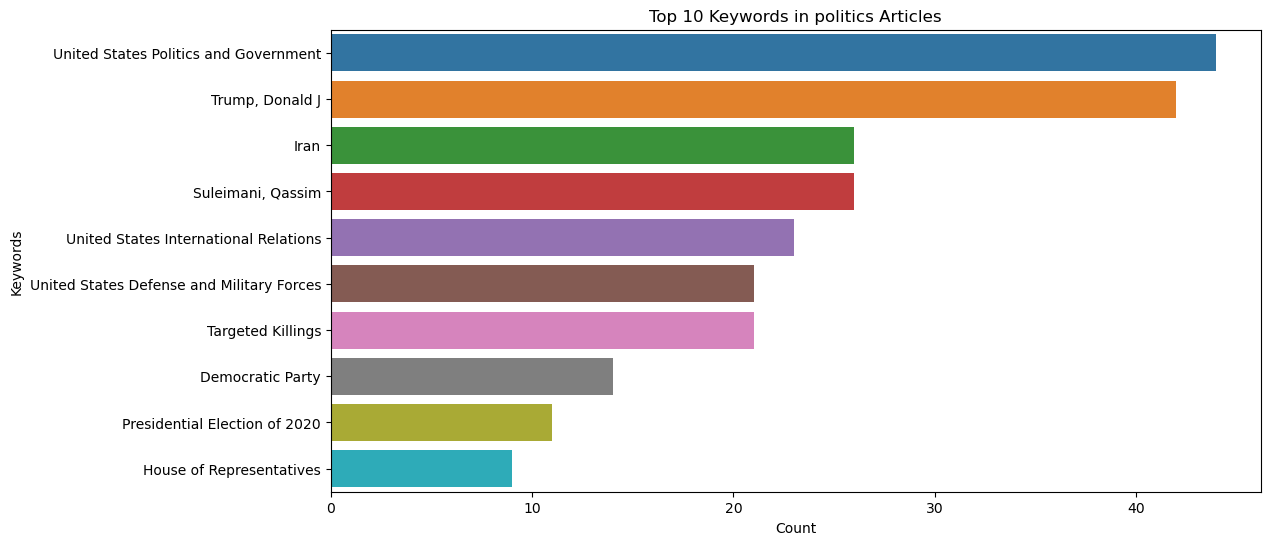

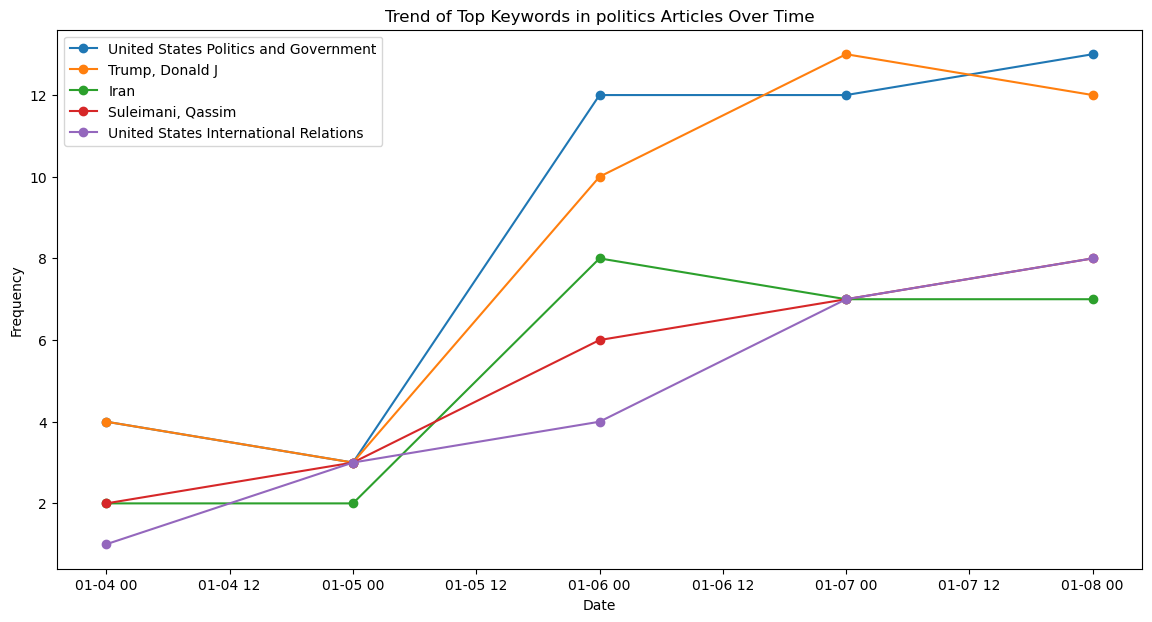

In [12]:
import requests
import pandas as pd
from config import API_KEY
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

def fetch_articles(topic, begin_date, end_date, API_KEY):
    base_url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json'
    all_articles = [] #initialize
    
    current_date = pd.Timestamp(begin_date)
    end_date = pd.Timestamp(end_date)
    
    if (end_date - current_date).days <= 30: #appropriate for graph
        delta = timedelta(days=1)
    else:
        delta = timedelta(weeks=1)

    while current_date < end_date:
        next_date = current_date + delta
        parameters = {
            'api-key': API_KEY,
            'q': topic,
            'fq': 'document_type:("article")',
            'begin_date': current_date.strftime('%Y%m%d'),
            'end_date': next_date.strftime('%Y%m%d'),
            'page': 0 
        }
        
        while True:
            response = requests.get(base_url, params=parameters)
            data = response.json()
            
            if 'response' in data and 'docs' in data['response']:
                articles = data['response']['docs']
                for article in articles:
                    headline = article.get('headline', {}).get('main', '')
                    pub_date = article.get('pub_date', None)
                    keywords = [keyword['value'] for keyword in article.get('keywords', [])]
                    
                    if pub_date:
                        all_articles.append({'headline': headline, 'pub_date': pub_date, 'keywords': keywords})

                if len(articles) < 10: 
                    break  
                else:
                    parameters['page'] += 1
            else:
                break
        
        current_date = next_date 
    
    return pd.DataFrame(all_articles)

def analyze_articles(df):
    if 'pub_date' not in df.columns: #was getting some errors earlier
        raise KeyError("'pub_date' column is missing in the DataFrame")

    # convert pub_date to datetime
    df['pub_date'] = pd.to_datetime(df['pub_date'])
    
    #occurrence of unique keywords
    all_keywords = [keyword for keywords in df['keywords'] for keyword in keywords]
    keyword_counts = pd.Series(all_keywords).value_counts().head(10)
    
    #frequency of words over time
    df['date'] = df['pub_date'].dt.date
    keyword_trends = df.explode('keywords').groupby(['date', 'keywords']).size().unstack(fill_value=0)
    top_keywords = keyword_trends.sum().nlargest(5).index
    top_keyword_trends = keyword_trends[top_keywords]
        
    return keyword_counts, top_keyword_trends

def plot_keyword_counts(keyword_counts, topic):
    # plot top 10 keywords
    plt.figure(figsize=(12, 6))
    sns.barplot(x=keyword_counts.values, y=keyword_counts.index)
    plt.title(f'Top 10 Keywords in {topic} Articles')
    plt.xlabel('Count')
    plt.ylabel('Keywords')
    plt.show()

def plot_keyword_trends(top_keyword_trends, topic):
    # plot trends over time
    plt.figure(figsize=(14, 7))
    for keyword in top_keyword_trends.columns:
        plt.plot(top_keyword_trends.index, top_keyword_trends[keyword], label=keyword, marker='o')
    
    plt.title(f'Trend of Top Keywords in {topic} Articles Over Time')
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def main():
    print("Hello User! This program will take in a section (topic) and a date from which a week will be added to see what keywords are most discussed.")
    topic = input("Topic you would like to query: ")
    begin_date = input("Enter the start date (YYYYMMDD): ")
    end_date = input("Enter the end date (YYYYMMDD): ")

    all_articles_df = fetch_articles(topic, begin_date, end_date, API_KEY)
    
    keyword_counts, top_keyword_trends = analyze_articles(all_articles_df)
    
    plot_keyword_counts(keyword_counts, topic)
    plot_keyword_trends(top_keyword_trends, topic)

if __name__ == "__main__":
    main()